Retrospective target inference (RTI) approach from Beata's paper: 

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from copy import deepcopy
import glob
import sys

[sys.path.append(f) for f in glob.glob('utils/*')]
from preprocess import DataStruct
from firingrate import raster2FR
from plotting_utils import figSize
from lineplots import plotsd
from hmm_utils import *
from hmm import *
from session_utils import *
from recalibration_utils import *
from click_utils import *

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import FactorAnalysis, PCA

files          = glob.glob('D:/T5_ClosedLoop/*')
click_sessions = get_Sessions(files, min_nblocks = 1, getClick = True)  

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Text(0, 0.5, 'Cursor y pos')

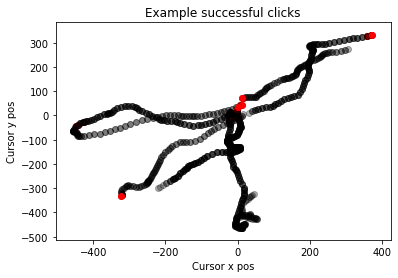

In [60]:
session        = DataStruct(click_sessions[1], alignScreens = True)
success_clicks = np.where(np.logical_and(session.decClick_continuous == 1, session.onTarget == 1))[0]


for i in range(120, 140):
    click        = success_clicks[i]
    cursor_retro = session.cursorPos_continuous[(click - 60):click, :]
    plt.scatter(cursor_retro[:, 0], cursor_retro[:, 1], color = 'k', alpha = 0.3)
    plt.scatter(cursor_retro[-1, 0], cursor_retro[-1, 1], color = 'r')
plt.title('Example successful clicks')
plt.xlabel('Cursor x pos')
plt.ylabel('Cursor y pos')

In [65]:
def get_RTIData(neural, cursor, isClick, onTarget, lookback = 60):
    '''Generate neural features and target error signals via retrospective calibration
       approach. Inputs are:
       
           neural (2D array)   - time x channels array of neural recordings
           cursor (2D array)   - time x 2
           isClick (1D array)  - binary-valued array of decoded clicks
           onTarget (1D array) - indicates if cursor hovering over valid item 
           lookback (int)      - number of previous timepoints from a click to use
    '''
    success_clicks    = np.where(np.logical_and(isClick == 1, onTarget == 1))[0]
    features, targets = list(), list()
    
    for i in success_clicks:
        targ          = session.cursorPos_continuous[i, :]  
        neural_retro  = session.TX_continuous[(i - lookback):i, :]
        curErr_retro  = targ - session.cursorPos_continuous[(i - lookback):i, :]  

        features.append(neural_retro), targets.append(curErr_retro)

    features = np.vstack(features)
    targets  = np.vstack(targets)

    return features, targets

    

In [74]:
lookback   = 60     # time points prior to consider 
train_frac = 0.5


session       = DataStruct(click_sessions[1], alignScreens = True)
session_len   = len(session.decClick_continuous)
n_train       = int(train_frac * session_len)


train_x        = session.TX_continuous[:n_train, :]
train_y        = (session.targetPos_continuous - session.cursorPos_continuous)[:n_train, :]
train_cursor   = session.cursorPos_continuous[:n_train, :]
train_click    = session.decClick_continuous[:n_train]
train_onTarget = session.onTarget[:n_train] 

train_xRTI, train_yRTI = get_RTIData(train_x, train_cursor, train_click, onTarget = train_onTarget, lookback = lookback)
test_x                 = session.TX_continuous[n_train:, :]
test_y                 = (session.targetPos_continuous - session.cursorPos_continuous)[n_train:, :]

# supervised recalibration:
print('Supervised recal decoder: R2 = ', LinearRegression().fit(train_x, train_y).score(test_x, test_y))

# RTI approach:
print('RTI decoder: R2 = ', LinearRegression().fit(train_xRTI, train_yRTI).score(test_x, test_y))



Supervised recal decoder: R2 =  0.4497145217683415
RTI decoder: R2 =  0.41288213192044837


(84816,)